In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import en_vectors_web_lg
from IPython.display import display_markdown
from sklearn.model_selection import train_test_split

from shared import models
from shared.data import load_imdb
from shared.models_store import Store
from machine_learning.cache import get_preprocessed_data
from machine_learning.plot_helpers import display_example_predictions, describe_data
from machine_learning.evaluation import evaluate_and_report

Using TensorFlow backend.


In [2]:
nlp = en_vectors_web_lg.load()

In [3]:
MAX_WORDS_IN_SENTENCE = 300
LIMIT = -1
dataset_id = 'imdb_{}'.format(LIMIT if LIMIT > 0 else 'all')
SAVE_IN_STORE = True

In [4]:
print("Loading training data...")
X_train, y_train = load_imdb('../data/aclImdb/train', limit=LIMIT)

print("Loading test data...")
# lower text count, because of memory problems when trying to load all
test_limit = LIMIT if 0 <= LIMIT <= 1000 else 1000
X_test, y_test = load_imdb('../data/aclImdb/test', limit=test_limit)

Loading training data...
Loading test data...


In [8]:
describe_data(X_train, y_train)

display_markdown('### Train count: {}'.format(len(X_train)), raw=True)
display_markdown('### Test count:  {}'.format(len(X_test)), raw=True)

### Data sample

,X,y
0,"b""Dan Katzir has produced a wonderful film tha...",1
1,b'If you want Scream or anything like the big-...,1
2,"b""Outlandish premise that rates low on plausib...",0
3,b'Let\'s face it-- if you rented a STDVD seque...,0
4,b'Bizarre Tobe Hooper exercise regarding an un...,0
5,"b'Well, maybe the PC version of this game was ...",0
6,"b'Watching ""Kroko"" I would have liked to leave...",0
7,"b""First of all, I have to start this comment b...",1
8,"b""Very much a film from the times -- extremely...",0
9,"b'""The Invisible Ray"" is part science fiction ...",1


#### Text stats

count                                                 25000
unique                                                24904
top       b"When i got this movie free from my job, alon...
freq                                                      3
Name: X, dtype: object

#### Words length stats

count    25000.000000
mean       233.776720
std        173.715418
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: X, dtype: float64

#### Labels stats

count    25000.00000
mean         0.50000
std          0.50001
min          0.00000
25%          0.00000
50%          0.50000
75%          1.00000
max          1.00000
Name: y, dtype: float64

#### Labels counts

1    12500
0    12500
Name: y, dtype: int64

1    0.5
0    0.5
Name: y, dtype: float64

### Train count: 25000

### Test count:  1000

In [5]:
# helper for saving models for reuse in web application
store = Store(nlp, '../dist/store.json')
input_samples = [
    "This movie is, in my opinion, very worth watching!",
    "I kinda liked that movie. Maybe it's not as good as other, but still watchable",
    "I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!",
]

def train_model_and_display_results(model, X=X_train, y=y_train, **train_params):
    display_markdown('## {}'.format(model.__class__.__name__), raw=True)
    display_markdown('#### Training', raw=True)
    model.load_or_train(X, y, **train_params)

    display_markdown("#### Overview of created model", raw=True)
    display(model.summary())

    display_markdown('#### Model results', raw=True)
    display_example_predictions(model, input_samples)
    return evaluate_and_report(model, X_test, y_test)

Loading cached data...
Loaded data from 'kerasmodel_imdb_all.h5'


## KerasModel

#### Training

Loading model...
Model 'keras_imdb_all_999bd479.h5' loaded


#### Overview of created model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 296, 32)           48032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 59, 32)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 59, 32)            128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 55, 64)            10304     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

None

#### Model results

#### Predicted scores

,score,text
0,0.958829,"This movie is, in my opinion, very worth watching!"
1,0.786654,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.001080,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Highest 5

,pred,prob,real,text
2,1.000000,1.000000,1,"b""I caught this movie on the Horror Channel and was quite impressed by the film's Gothic atmosphere and tone. As a big fan of ..."
21,1.000000,1.000000,1,"b'Big Fat Liar is a great watch for kids of all ages, even adults. I had a great time watching this movie and recommend this t..."
28,1.000000,1.000000,1,"b""This is a very modest, very lovely movie with a great score by Hoagy Carmichael and Frank Loesser with a standout number, We..."
40,1.000000,1.000000,1,"b'This is my favourite kung fu movie. It has a very authentic flavour, seasoned by an eerie music score (of tradition chinese ..."
42,1.000000,1.000000,1,"b""I just finished watching the movie tonight and I truly loved it. John Denver didn't play a pastor, but it was the reverend o..."


#### Lowest 5

,pred,prob,real,text
934,0.000000,0.000000,0,b'There is an endless supply of trashy horror movies. It seems that people never get tired of trying to scare and thrill. Alas...
679,0.000000,0.000000,0,"b'""Beowulf"" is like a very bad game : no characters, no story, no real dialogues, bad fights ... It\'s probably the worst movi..."
305,0.000000,0.000000,0,"b""Dorothy Stratten is the only reason to watch this unfunny sci-fi spoof, and her appearance is a disappointment. Though she h..."
337,0.000000,0.000000,0,"b""A waste of time, talent and shelf space, this is a truly abysmal film. What are big leaguers like Keanu Reeves, Cameron Diaz..."
38,0.000000,0.000000,0,b'What an utter disappointment. Forget this abysmal film and get hold of the TV series instead. What on earth were they doing ...


#### Highest 5 mispredicted

,pred,prob,real,text
523,1.000000,1.000000,0,"b""This film has the language, the style and the attitude down ... plus greats rides from Occy (a world champ) and the great Je..."
71,1.000000,1.000000,0,"b'I went to see this 3 nights ago here in Cork, Ireland. It was the world premiere of it, in the tiny cinema in the Triskel Ar..."
978,1.000000,0.999997,0,"b""It beats me how anyone can rate this film very highly. It is no understatement to call it far fetched. How the guy managed i..."
517,1.000000,0.999984,0,"b""Interesting and short television movie describes some of the machinations surrounding Jay Leno's replacing Carson as host of..."
954,1.000000,0.999980,0,"b'Uninspired, pretty much all around. The only exceptions were a couple emotional scenes with Keena (Violet), with whose perfo..."


#### Lowest 5 mispredicted

,pred,prob,real,text
821,0.000000,0.000194,1,"b'Sam Firstenberg\'s ""Ninja 3:The Domination"" mixes martial arts with ""The Exorcist"" like horror.The horror elements thrown on..."
649,0.000000,0.006571,1,"b""Overall, I enjoyed the movie Scarlett. I am a huge fan of Gone with the Wind. I have read the book and seen the classic movi..."
244,0.000000,0.022926,1,"b""If a joke doesn't offend anybody, it isn't funny.<br /><br />The Inki cartoons are offensive, no doubt about it. So is rap m..."
549,0.000000,0.031159,1,b'Where do I start. Do I say how great the cinematography is. Do I praise certain scenes which show the directors creativity. ...
194,0.000000,0.111465,1,"b'You got to love this movie! I mean, what other Swedish splatter movie could be so evil, bizarre and totally cruel...The whol..."


#### Classification report for keras

             precision    recall  f1-score   support

   Negative       0.94      0.58      0.72       498
   Positive       0.70      0.96      0.81       502

avg / total       0.82      0.78      0.77      1000



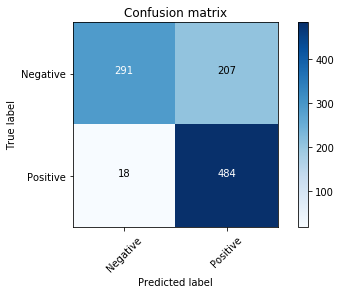

In [7]:
keras_model = models.KerasModel(
    nlp, 
    dataset_id, 
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    epochs=50)

X_keras_preprocessed = get_preprocessed_data(keras_model, dataset_id, X_train)

accuracy = train_model_and_display_results(keras_model, X_keras_preprocessed, preprocessed=True)

if SAVE_IN_STORE:
    store.add_model(keras_model, "conv1d_imdb", "IMDB Conv1d", metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': len(X_train),
        'Accuracy': accuracy,
        'Description': "1D Convolutional network defined using Keras and trained on a publicly-available dataset"
    })

# we need memory for further processing
del X_keras_preprocessed

In [8]:
# preprocessed data for all sklearn-based models

model = models.SklearnModel(nlp, dataset_id)
X_sklearn_preprocessed = get_preprocessed_data(model, dataset_id, X_train)

Loading cached data...
Unable to load data, preprocessing...
Preprocessed and saved to 'sklearnmodel_imdb_all.h5'


## SVCModel

#### Training

Loading model...
Unable to load model, training...


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model 'svc_imdb_all_80e28a4f.pkl' saved


#### Overview of created model

SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Model results

#### Predicted scores

,score,text
0,0.988949,"This movie is, in my opinion, very worth watching!"
1,0.044466,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.060011,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Highest 5

,pred,prob,real,text
75,1.000000,1.000000,1,"b'For those that are great fans and collectors of dinosaurs like I am, it is not only a very informative series but also puts ..."
284,1.000000,1.000000,1,"b'When you want to celebrate life and love, especially for precious little daughters, you have to shout it from the countrysid..."
877,1.000000,1.000000,1,"b'Otto Preminger\'s ""Porgy and Bess"" stands, to date, as a great American musical. I believe it is time bring this film out on..."
982,1.000000,0.999998,1,"b""This a wonderful sequel to the award winning Lonesome Dove miniseries in the 1980's. This sequel is perhaps, better than the..."
262,1.000000,0.999997,1,"b'In ""Lassie Come Home,"" ""National Velvet,"" and ""The Courage of Lassie,"" Elizabeth Taylor was eleven years old \xc2\x85 Nevert..."


#### Lowest 5

,pred,prob,real,text
265,0.000000,0.000676,0,"b'Idiots go camping and act like idiots before they finally die like idiots, yes Camp Blood (or if you\'re wanting an awful, b..."
297,0.000000,0.000703,0,"b""Killjoy 2 is the same as killjoy 1. Bad acting, bad characters, annoying clown, bad lines, you name it. Honestly, I'm not al..."
837,0.000000,0.001217,0,"b'As Anthony Bourdain said... ""I wanted to stick my head in a bucket of lye, pull my eyeballs out and jump off a cliff."" This ..."
956,0.000000,0.001334,0,"b'What could have been some majorly creepy stuff ends up being an incomprehensible, nutty motion picture that even the filmmak..."
145,0.000000,0.001507,0,"b""I would rather have someone cut out my eyeballs with a razor blade than have to watch this movie again. I watched it from st..."


#### Highest 5 mispredicted

,pred,prob,real,text
523,1.000000,0.999995,0,"b""This film has the language, the style and the attitude down ... plus greats rides from Occy (a world champ) and the great Je..."
71,1.000000,0.942049,0,"b'I went to see this 3 nights ago here in Cork, Ireland. It was the world premiere of it, in the tiny cinema in the Triskel Ar..."
517,1.000000,0.939821,0,"b""Interesting and short television movie describes some of the machinations surrounding Jay Leno's replacing Carson as host of..."
224,1.000000,0.937982,0,"b""Well, I think I've finally seen my last Woody Allen movie! I read the review in the newspaper and went to see this movie wit..."
708,1.000000,0.935255,0,b'The filmmaker stayed true to the most accurate account of the story published in 1894 which includes an 1846 manuscript by R...


#### Lowest 5 mispredicted

,pred,prob,real,text
244,0.000000,0.001539,1,"b""If a joke doesn't offend anybody, it isn't funny.<br /><br />The Inki cartoons are offensive, no doubt about it. So is rap m..."
553,0.000000,0.014293,1,"b""yes barney is nonsense now but when i was a kid it made perfect sense.<br /><br />i haven't gotten any smarter but i enjoyed..."
924,0.000000,0.044952,1,"b""Might contain spoilers.<br /><br />This is just a good movie. Lots of good silly stuff to laugh at. However, do not watch th..."
539,0.000000,0.058629,1,"b""i would give this movie an 8.5 or a 9. I thought it was just straight up hilarious i don't know how you could not think this..."
326,0.000000,0.060619,1,b'I can\'t even begin to imagine why everyone hates this movie so much. It had me literally crying with laughter several times...


#### Classification report for svc

             precision    recall  f1-score   support

   Negative       0.81      0.84      0.83       498
   Positive       0.84      0.81      0.82       502

avg / total       0.83      0.82      0.82      1000



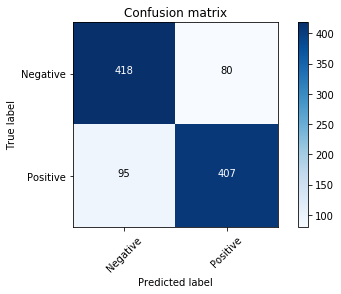

In [9]:
# it's almost impossible to train SVC on full dataset due to time complexity
svc_limit = min(20000, len(X_sklearn_preprocessed))
svc_model = models.SVCModel(
    nlp, dataset_id, 
    kernel="linear", C=0.025,
    probability=True)

accuracy = train_model_and_display_results(
    svc_model,
    X_sklearn_preprocessed[:svc_limit], 
    y_train[:svc_limit], 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(svc_model, "svc_imdb", "IMDB SVC", metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': svc_limit,
        'Accuracy': accuracy,
        'Description': "SVM algorithm from Sklearn package. Trained on a reduced dataset due to O(n^2) time complexity"
    })


## DecisionTreeModel

#### Training

Loading model...
Unable to load model, training...
Model 'decisiontreeclassifier_imdb_all_5099b258.pkl' saved


#### Overview of created model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Model results

#### Predicted scores

,score,text
0,0.700000,"This movie is, in my opinion, very worth watching!"
1,0.079453,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.474708,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Highest 5

,pred,prob,real,text
21,1.000000,0.956822,1,"b'Big Fat Liar is a great watch for kids of all ages, even adults. I had a great time watching this movie and recommend this t..."
35,1.000000,0.956822,1,"b""Out of all the Bat-films, Batman Returns is my favorite. This beautiful, dark, and funny film is one of Tim Burton's best wo..."
36,1.000000,0.956822,1,"b""'Opera' (1987) <br /><br />Director: Dario Argento (Deep Red, Suspiria) Screenplay: Dario Argento and Franco Ferrini (The Ch..."
78,1.000000,0.956822,1,"b""In August Days/Dies d'agost Marc Recha has given us a sun-saturated Catalan documentary-style road movie that's mostly a mea..."
84,1.000000,0.956822,1,"b""I've seen this movie at least 8 times, and I still laugh every time. The movie is about how an intelligent and motivated man..."


#### Lowest 5

,pred,prob,real,text
3,0.000000,0.079453,0,"b'NBC had a chance to make a powerful religious epic along the lines of ""The Ten Commandments"" and ""The Greatest Story Ever To..."
8,0.000000,0.079453,0,"b'Ocean\'s Twelve: just plain stupid, bad and nothing compared to the other two.<br /><br />An art robbery. 10 known actors, a..."
23,0.000000,0.079453,0,"b""1 hour and 40 minutes of talking--boring talking, and more talking and then some. It is hard for me to grasp how an actress ..."
26,0.000000,0.079453,0,"b""I thought this is an unbelievable boring movie! i heard the director can't speak french and so he left his actors tell what ..."
39,0.000000,0.079453,0,b'Milla stands out in this movie because of her personal sense of style and the way the clothes hang on her. I have learned to...


#### Highest 5 mispredicted

,pred,prob,real,text
226,1.000000,0.956822,0,b'This is simply another bad Chuck Norris movie. Norris plays a cop on the trail of a twisted serial killer of women. He put t...
462,1.000000,0.956822,0,"b""This movie has been a classic in my part of the country because it was filmed in my own small town. I now have many friends ..."
523,1.000000,0.956822,0,"b""This film has the language, the style and the attitude down ... plus greats rides from Occy (a world champ) and the great Je..."
627,1.000000,0.898488,0,"b'Really!Here the French cinema hits rock bottom ,and compared to it, the least appealing of the American adolescent horror mo..."
690,1.000000,0.898488,0,"b""The story is: a turn-of-the-century troupe of actors, along with producers and theatre-owners, have very complicated relatio..."


#### Lowest 5 mispredicted

,pred,prob,real,text
169,0.000000,0.079453,1,"b'This movie is a hard-to-find gem! It is the story of Juliette, a perfectly ordinary cleaning woman who works in the large co..."
245,0.000000,0.079453,1,"b'""For a Squadron Leader - normally the only guy trained and equipped for navigation in a squadron and very hard to replace - ..."
326,0.000000,0.079453,1,b'I can\'t even begin to imagine why everyone hates this movie so much. It had me literally crying with laughter several times...
387,0.000000,0.079453,1,"b""if you are going to see this movie, by all means don't go into this movie with the expectation of this movie will be absolut..."
700,0.000000,0.079453,1,"b""I don't want to write too much about the film but basically it's an action/comedy with a little bit of romance thrown in abo..."


#### Classification report for decisiontreeclassifier

             precision    recall  f1-score   support

   Negative       0.73      0.69      0.71       498
   Positive       0.71      0.74      0.72       502

avg / total       0.72      0.71      0.71      1000



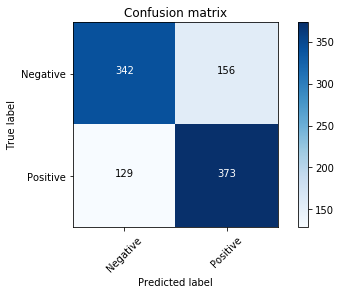

In [10]:
decision_tree_model = models.DecisionTreeModel(
    nlp, dataset_id, 
    max_depth=6)

accuracy = train_model_and_display_results(
    decision_tree_model, 
    X_sklearn_preprocessed, 
    preprocessed=True)

if SAVE_IN_STORE:
    store.add_model(decision_tree_model, "decision_tree_imdb", "IMDB Decision Tree", metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': len(X_sklearn_preprocessed),
        'Accuracy': accuracy,
        'Description': "Decision Tree algorithm from Sklearn package."
    })

## MLPModel

#### Training

Loading model...
Unable to load model, training...
Iteration 1, loss = 0.53806308


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 2, loss = 0.37793423
Iteration 3, loss = 0.35682913
Iteration 4, loss = 0.34721349
Iteration 5, loss = 0.34474215
Iteration 6, loss = 0.33620934
Iteration 7, loss = 0.33472883
Iteration 8, loss = 0.33101201
Iteration 9, loss = 0.33244794
Iteration 10, loss = 0.32769541
Iteration 11, loss = 0.32448834
Iteration 12, loss = 0.32960638
Iteration 13, loss = 0.32462216
Iteration 14, loss = 0.32086929
Iteration 15, loss = 0.32352313
Iteration 16, loss = 0.31945241
Iteration 17, loss = 0.31882223
Iteration 18, loss = 0.31386002
Iteration 19, loss = 0.31357674
Iteration 20, loss = 0.31253640
Iteration 21, loss = 0.31002074
Iteration 22, loss = 0.31225532
Iteration 23, loss = 0.31106052
Iteration 24, loss = 0.30742737
Iteration 25, loss = 0.30404316
Iteration 26, loss = 0.30292591
Iteration 27, loss = 0.30411417
Iteration 28, loss = 0.30519288
Iteration 29, loss = 0.29861733
Iteration 30, loss = 0.29896246
Iteration 31, loss = 0.29733738
Iteration 32, loss = 0.29671517
Iteration 33, lo

#### Overview of created model

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=50, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

#### Model results

#### Predicted scores

,score,text
0,0.999123,"This movie is, in my opinion, very worth watching!"
1,0.688288,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.686890,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Highest 5

,pred,prob,real,text
75,1.000000,0.999449,1,"b'For those that are great fans and collectors of dinosaurs like I am, it is not only a very informative series but also puts ..."
427,1.000000,0.999442,1,b'Very glad to see that this excellent film gets such high marks from the users of IMDB. The Best Years of Their Lives remains...
983,1.000000,0.999416,1,"b""At the 2005 Phoenix Film Festival, it was no secret which film ranked at the top of everyone's viewing list. Checking Out (2..."
819,1.000000,0.999409,1,"b""I thought that this is a wonderfully written movie. I love little Scamp, and the street-wise Angel. This movie is very easy ..."
214,1.000000,0.999246,1,"b""The biggest heroes, is one of the greatest movies ever. A good story, great actors and a brilliant ending is what makes this..."


#### Lowest 5

,pred,prob,real,text
837,0.000000,0.000226,0,"b'As Anthony Bourdain said... ""I wanted to stick my head in a bucket of lye, pull my eyeballs out and jump off a cliff."" This ..."
720,0.000000,0.000270,0,"b'To soccer fans every where -- stay away from this movie. It was so baaaaddd! Lame acting, lame script, lame soccer and no di..."
82,0.000000,0.000555,0,"b'That was a waste of 9 dollars. the movie was terrible. all the ""scary"" parts were pointless and sadly repetitive. Seemingly ..."
197,0.000000,0.000689,0,"b'Anyone who knows anything about evolution wouldn\'t even need to see the film to say ""fake"". ""it\'s never been disproved"" al..."
150,0.000000,0.000832,0,"b'Usual awful movie... I\'ll not bother you about the synopsis, just put together The Core, Armageddon, an evil-planner Milita..."


#### Highest 5 mispredicted

,pred,prob,real,text
523,1.000000,0.998667,0,"b""This film has the language, the style and the attitude down ... plus greats rides from Occy (a world champ) and the great Je..."
545,1.000000,0.984308,0,"b'Note to self. Never ever ever again watch a serious movie with Charlie Sheen in it. Great comedian, horrible seal. This movi..."
34,1.000000,0.981001,0,"b""Since I am not a big Steven Seagal fan, I thought this was a pretty good movie. It is apparent that his fans are very disple..."
65,1.000000,0.980274,0,b'Not the funniest movie ever.....but I have to watch this film at least once a year just so I can fall in Love with Michelle ...
659,1.000000,0.973124,0,"b""My ratings: Acting - 3/10 Suspense - 2/10 Character Attachment - 1/10 Plot - 2/10 Character Development - 2/10 Overall - 2/1..."


#### Lowest 5 mispredicted

,pred,prob,real,text
897,0.000000,0.022145,1,b'If you value your freedom!<br /><br />I first got seriously interested in The Branch Davidian debacle after reading an artic...
43,0.000000,0.022989,1,"b""The casting of Robert Culp is probably the only decent move the production team made with this film. Falk and Culp were marv..."
244,0.000000,0.024823,1,"b""If a joke doesn't offend anybody, it isn't funny.<br /><br />The Inki cartoons are offensive, no doubt about it. So is rap m..."
958,0.000000,0.044192,1,"b'I can honestly say that ""Death Bed: The Bed That Eats"" was a much better movie than I expected. Allow me to clarify the plot..."
610,0.000000,0.048435,1,b'...and normally i don\'t like surprises!! Watch this movie by chance in a motel in South Africa second week of a three month...


#### Classification report for mlpclassifier

             precision    recall  f1-score   support

   Negative       0.89      0.82      0.85       498
   Positive       0.84      0.90      0.87       502

avg / total       0.86      0.86      0.86      1000



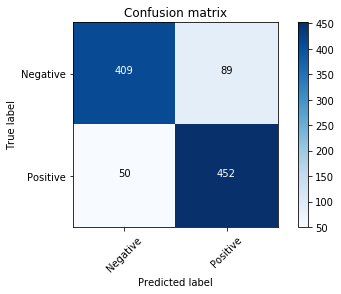

In [11]:
mlp_model = models.MLPModel(
    nlp, dataset_id,
    hidden_layer_sizes=(50, 50), 
    max_iter=50, 
    verbose=True)

accuracy = train_model_and_display_results(
    mlp_model,
    X_sklearn_preprocessed, 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(mlp_model, "mlp_imdb", "IMDB Multi-Layer Perceptron", metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': len(X_sklearn_preprocessed),
        'Accuracy': accuracy,
        'Description': "MLP algorithm from Sklearn package, with 50x50 hidden layers sizes"
    })

## GaussianNBModel

#### Training

Loading model...
Unable to load model, training...
Model 'gaussiannb_imdb_all_d41d8cd9.pkl' saved


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Overview of created model

GaussianNB(priors=None)

#### Model results

#### Predicted scores

,score,text
0,1.0,"This movie is, in my opinion, very worth watching!"
1,1.0,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,1.0,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Highest 5

,pred,prob,real,text
0,1.000000,1.000000,1,"b""Don't hate Heather Graham because she's beautiful, hate her because she's fun to watch in this movie. Like the hip clothing ..."
2,1.000000,1.000000,1,"b""I caught this movie on the Horror Channel and was quite impressed by the film's Gothic atmosphere and tone. As a big fan of ..."
6,1.000000,1.000000,1,"b""I think this is one hell of a movie...........We can see Steven fighting around with his martial art stuff again and like in..."
9,1.000000,1.000000,1,"b""This excellent movie starring Elizabeth Montgomery is long overdue for release in DVD form. The same can be said for her ear..."
21,1.000000,1.000000,1,"b'Big Fat Liar is a great watch for kids of all ages, even adults. I had a great time watching this movie and recommend this t..."


#### Lowest 5

,pred,prob,real,text
619,0.000000,0.000000,0,"b'This movie has got to be about one of the worst i have ever seen. The humor was crude, hardly funny and been heard a million..."
575,0.000000,0.000000,0,"b""Bloody Birthday is a totally rubbish slasher movie from beginning to end. <br /><br />I found the acting to be pretty good c..."
956,0.000000,0.000000,0,"b'What could have been some majorly creepy stuff ends up being an incomprehensible, nutty motion picture that even the filmmak..."
145,0.000000,0.000000,0,"b""I would rather have someone cut out my eyeballs with a razor blade than have to watch this movie again. I watched it from st..."
265,0.000000,0.000000,0,"b'Idiots go camping and act like idiots before they finally die like idiots, yes Camp Blood (or if you\'re wanting an awful, b..."


#### Highest 5 mispredicted

,pred,prob,real,text
34,1.000000,1.000000,0,"b""Since I am not a big Steven Seagal fan, I thought this was a pretty good movie. It is apparent that his fans are very disple..."
73,1.000000,1.000000,0,"b'Problems: 1) Although billed as ""a loving tribute to Poverty Row,"" a lot of the old footage is not even from Poverty Row fil..."
116,1.000000,1.000000,0,"b'While studying the differences between religion and cult in college, Mindy (Rachel Miner), who is the best student in the cl..."
120,1.000000,1.000000,0,"b'Pat O\'Brien portrays Knute Rockne, the All-American Notre Dame football coach. No doubt, this film will be considerably mor..."
143,1.000000,1.000000,0,"b""Jason Lee does well to give this doggy movie fleeting promise, but it's not enough to distinguish it from any other bland fa..."


#### Lowest 5 mispredicted

,pred,prob,real,text
924,0.000000,0.000000,1,"b""Might contain spoilers.<br /><br />This is just a good movie. Lots of good silly stuff to laugh at. However, do not watch th..."
717,0.000000,0.000000,1,b'i haven\'t seen this in years but when i was about 6 i first saw this on VHS and i must have watched it at least 10 times. n...
467,0.000000,0.000000,1,"b""yes, i have noticed that there are 347 other comments, i think that is a good sign for a movie, even if some are negative. i..."
965,0.000000,0.000000,1,"b""The very few reviews I could find online of Barnens \xc3\xb6 really do not do it justice. I read them all before ordering th..."
879,0.000000,0.000000,1,"b'One of the most macabre, depressing, yet eye-opening docs. I\'ve watched in awhile. There\'s no narration or story that\'s t..."


#### Classification report for gaussiannb

             precision    recall  f1-score   support

   Negative       0.67      0.77      0.72       498
   Positive       0.74      0.63      0.68       502

avg / total       0.71      0.70      0.70      1000



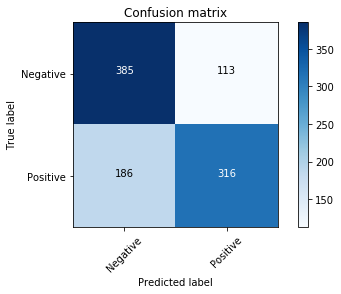

In [12]:
gaussian_nb_model = models.GaussianNBModel(
    nlp, dataset_id
)

accuracy = train_model_and_display_results(
    gaussian_nb_model,
    X_sklearn_preprocessed, 
    preprocessed=True
)


if SAVE_IN_STORE:
    store.add_model(gaussian_nb_model, "gnb_imdb", "IMDB Gaussian Naive Bayes", metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': len(X_sklearn_preprocessed),
        'Accuracy': accuracy,
        'Description': "GaussianNB algorithm from Sklearn package, default options"
    })

## AdaBoostModel

#### Training

Loading model...
Unable to load model, training...


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model 'adaboostclassifier_imdb_all_d41d8cd9.pkl' saved


#### Overview of created model

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

#### Model results

#### Predicted scores

,score,text
0,0.510652,"This movie is, in my opinion, very worth watching!"
1,0.486407,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.502071,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Highest 5

,pred,prob,real,text
428,1.000000,0.537114,1,"b'These critics need to find a new job!!! This movie is based on a TRUE STORY, which has made history. It illustrates beautifu..."
762,1.000000,0.535769,1,"b""The movie has taken a little flack for playing fast and loose with the facts. But it will put you close to being in a time a..."
818,1.000000,0.532010,1,"b""1981's Just Before Dawn is one of the best tales of wilderness horror out there. It's one of the finest-made slashers of the..."
307,1.000000,0.531643,1,"b""I have seen this film on a Sunday evening and I must say there is no better way to end the weekend. I am totally pleased wit..."
66,1.000000,0.530431,1,"b'Love Jones cleverly portrays young African-American men and women in a clear, positive, realistic sense. I feel that all of ..."


#### Lowest 5

,pred,prob,real,text
265,0.000000,0.464389,0,"b'Idiots go camping and act like idiots before they finally die like idiots, yes Camp Blood (or if you\'re wanting an awful, b..."
837,0.000000,0.468950,0,"b'As Anthony Bourdain said... ""I wanted to stick my head in a bucket of lye, pull my eyeballs out and jump off a cliff."" This ..."
541,0.000000,0.471254,0,"b'This movie was pointless. I can\'t even call it sci-fi, since that requires more from a movie than merely taking place in sp..."
781,0.000000,0.471262,0,"b""why oh why did i ever waste my time watching this film? it was given to me on video by a friend and i thought i'll watch it,..."
870,0.000000,0.471542,0,"b'The spoof genre, which has lacked creativity and humor for some time already, gets spat upon yet again by hacks with no tale..."


#### Highest 5 mispredicted

,pred,prob,real,text
224,1.000000,0.526081,0,"b""Well, I think I've finally seen my last Woody Allen movie! I read the review in the newspaper and went to see this movie wit..."
523,1.000000,0.523544,0,"b""This film has the language, the style and the attitude down ... plus greats rides from Occy (a world champ) and the great Je..."
57,1.000000,0.518183,0,"b'Terrible. The only way I could even begin to consider it funny is if it made fun of itself. ""Amazing. It\'s about an ass tha..."
482,1.000000,0.517693,0,"b""Although this was the first Hunter S. Thompson documentary I have seen it was average at best despite the involvement's of h..."
11,1.000000,0.517682,0,"b""Even Disney are guilty of the cash cow disease, after the roaring success of The Love Bug in 1968, the house of mouse cashed..."


#### Lowest 5 mispredicted

,pred,prob,real,text
924,0.000000,0.473169,1,"b""Might contain spoilers.<br /><br />This is just a good movie. Lots of good silly stuff to laugh at. However, do not watch th..."
958,0.000000,0.483614,1,"b'I can honestly say that ""Death Bed: The Bed That Eats"" was a much better movie than I expected. Allow me to clarify the plot..."
244,0.000000,0.483891,1,"b""If a joke doesn't offend anybody, it isn't funny.<br /><br />The Inki cartoons are offensive, no doubt about it. So is rap m..."
417,0.000000,0.485617,1,"b""I'm not sure where to start with this. In short, it was a disappointing movie. Having taught the novella, I was aware that i..."
473,0.000000,0.486484,1,"b'this movie is funny funny funny my favorite quote from the movie ""i think i saw a half naked Indian in my room last night"" r..."


#### Classification report for adaboostclassifier

             precision    recall  f1-score   support

   Negative       0.82      0.80      0.81       498
   Positive       0.80      0.83      0.81       502

avg / total       0.81      0.81      0.81      1000



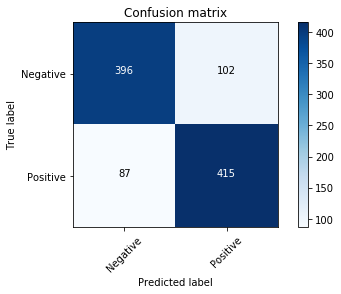

In [13]:
ada_boost_model = models.AdaBoostModel(
    nlp, dataset_id
)

accuracy = train_model_and_display_results(
    ada_boost_model,
    X_sklearn_preprocessed, 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(ada_boost_model, "ada_imdb", "IMDB Ada Boost", metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': len(X_sklearn_preprocessed),
        'Accuracy': accuracy,
        'Description': "Ada Boost algorithm from Sklearn package, default options"
    })

## QuadraticDiscriminantAnalysisModel

#### Training

Loading model...
Model 'quadraticdiscriminantanalysis_imdb_all_d41d8cd9.pkl' loaded


#### Overview of created model

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

#### Model results

#### Predicted scores

,score,text
0,1.000000,"This movie is, in my opinion, very worth watching!"
1,1.000000,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.001013,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Highest 5

,pred,prob,real,text
11,1.000000,1.000000,0,"b""Even Disney are guilty of the cash cow disease, after the roaring success of The Love Bug in 1968, the house of mouse cashed..."
21,1.000000,1.000000,1,"b'Big Fat Liar is a great watch for kids of all ages, even adults. I had a great time watching this movie and recommend this t..."
40,1.000000,1.000000,1,"b'This is my favourite kung fu movie. It has a very authentic flavour, seasoned by an eerie music score (of tradition chinese ..."
43,1.000000,1.000000,1,"b""The casting of Robert Culp is probably the only decent move the production team made with this film. Falk and Culp were marv..."
75,1.000000,1.000000,1,"b'For those that are great fans and collectors of dinosaurs like I am, it is not only a very informative series but also puts ..."


#### Lowest 5

,pred,prob,real,text
837,0.000000,0.000000,0,"b'As Anthony Bourdain said... ""I wanted to stick my head in a bucket of lye, pull my eyeballs out and jump off a cliff."" This ..."
338,0.000000,0.000000,0,"b""This was really the worst movie I've ever seen. Anyone who has seen it will know what I'm talking about. I saw it on Starz, ..."
725,0.000000,0.000000,1,"b'It\'s really good to see Van Damme\'s film are slowly getting better of late and especially compared to C-grade flops ""Derai..."
720,0.000000,0.000000,0,"b'To soccer fans every where -- stay away from this movie. It was so baaaaddd! Lame acting, lame script, lame soccer and no di..."
528,0.000000,0.000000,0,"b'Bad, a lot a crap. It copied simone, also a bad movie! Them flips when ""loretta modern"" sang was lame. That internet scenes ..."


#### Highest 5 mispredicted

,pred,prob,real,text
11,1.000000,1.000000,0,"b""Even Disney are guilty of the cash cow disease, after the roaring success of The Love Bug in 1968, the house of mouse cashed..."
120,1.000000,1.000000,0,"b'Pat O\'Brien portrays Knute Rockne, the All-American Notre Dame football coach. No doubt, this film will be considerably mor..."
247,1.000000,1.000000,0,"b""I saw this movie and I thought this is a stupid movie. What is even more stupid is that who had thought an idea that there s..."
343,1.000000,1.000000,0,"b'EVAN ALMIGHTY (2007) ** Steve Carell, Morgan Freeman, Lauren Graham, Johnny Simmons, Graham Phillips, Jimmy Bennett, John Go..."
523,1.000000,1.000000,0,"b""This film has the language, the style and the attitude down ... plus greats rides from Occy (a world champ) and the great Je..."


#### Lowest 5 mispredicted

,pred,prob,real,text
725,0.000000,0.000000,1,"b'It\'s really good to see Van Damme\'s film are slowly getting better of late and especially compared to C-grade flops ""Derai..."
897,0.000000,0.000000,1,b'If you value your freedom!<br /><br />I first got seriously interested in The Branch Davidian debacle after reading an artic...
550,0.000000,0.000000,1,"b""This thriller is one of the few (film) surprises I've had in quite some time. Everybody - and I do mean EVERYBODY - I talked..."
961,0.000000,0.000000,1,b'Ignore everyone else\'s comments for this movie and watch it on pay cable (like I did) or rent it. You owe it to yourself. T...
880,0.000000,0.000000,1,"b'I have never seen ""American Werewolf in London"" but this movie was very entertaining. When renting it I thought it was a hor..."


#### Classification report for quadraticdiscriminantanalysis

             precision    recall  f1-score   support

   Negative       0.68      0.83      0.75       498
   Positive       0.78      0.62      0.69       502

avg / total       0.73      0.72      0.72      1000



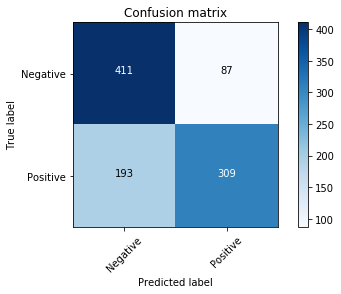

In [15]:
qda_model = models.QuadraticDiscriminantAnalysisModel(
    nlp, dataset_id
)

accuracy = train_model_and_display_results(
    qda_model,
    X_sklearn_preprocessed, 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(qda_model, "qda_imdb", "IMDB Quadratic Discriminant Analysis", metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': len(X_sklearn_preprocessed),
        'Accuracy': accuracy,
        'Description': "Quadratic Discriminant Analysis algorithm from Sklearn package, default options"
    })

## LogisticRegressionModel

#### Training

Loading model...
Unable to load model, training...


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model 'logisticregression_imdb_all_90795899.pkl' saved


#### Overview of created model

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

#### Model results

#### Predicted scores

,score,text
0,0.998702,"This movie is, in my opinion, very worth watching!"
1,0.481527,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.078397,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Highest 5

,pred,prob,real,text
75,1.000000,0.999986,1,"b'For those that are great fans and collectors of dinosaurs like I am, it is not only a very informative series but also puts ..."
982,1.000000,0.999913,1,"b""This a wonderful sequel to the award winning Lonesome Dove miniseries in the 1980's. This sequel is perhaps, better than the..."
819,1.000000,0.999877,1,"b""I thought that this is a wonderfully written movie. I love little Scamp, and the street-wise Angel. This movie is very easy ..."
428,1.000000,0.999841,1,"b'These critics need to find a new job!!! This movie is based on a TRUE STORY, which has made history. It illustrates beautifu..."
523,1.000000,0.999813,0,"b""This film has the language, the style and the attitude down ... plus greats rides from Occy (a world champ) and the great Je..."


#### Lowest 5

,pred,prob,real,text
837,0.000000,0.000004,0,"b'As Anthony Bourdain said... ""I wanted to stick my head in a bucket of lye, pull my eyeballs out and jump off a cliff."" This ..."
528,0.000000,0.000012,0,"b'Bad, a lot a crap. It copied simone, also a bad movie! Them flips when ""loretta modern"" sang was lame. That internet scenes ..."
720,0.000000,0.000013,0,"b'To soccer fans every where -- stay away from this movie. It was so baaaaddd! Lame acting, lame script, lame soccer and no di..."
418,0.000000,0.000014,0,"b'""Cleo\'s Second Husband"" is an amateurish attempt at psychodrama with more to fault than to praise. The plot is hacked, the ..."
265,0.000000,0.000036,0,"b'Idiots go camping and act like idiots before they finally die like idiots, yes Camp Blood (or if you\'re wanting an awful, b..."


#### Highest 5 mispredicted

,pred,prob,real,text
523,1.000000,0.999813,0,"b""This film has the language, the style and the attitude down ... plus greats rides from Occy (a world champ) and the great Je..."
71,1.000000,0.972409,0,"b'I went to see this 3 nights ago here in Cork, Ireland. It was the world premiere of it, in the tiny cinema in the Triskel Ar..."
11,1.000000,0.961680,0,"b""Even Disney are guilty of the cash cow disease, after the roaring success of The Love Bug in 1968, the house of mouse cashed..."
810,1.000000,0.954614,0,"b'I expected so much more than what I received from watching this movie. It is not that I object to literary license, (if that..."
65,1.000000,0.953910,0,b'Not the funniest movie ever.....but I have to watch this film at least once a year just so I can fall in Love with Michelle ...


#### Lowest 5 mispredicted

,pred,prob,real,text
821,0.000000,0.004812,1,"b'Sam Firstenberg\'s ""Ninja 3:The Domination"" mixes martial arts with ""The Exorcist"" like horror.The horror elements thrown on..."
244,0.000000,0.005137,1,"b""If a joke doesn't offend anybody, it isn't funny.<br /><br />The Inki cartoons are offensive, no doubt about it. So is rap m..."
958,0.000000,0.022089,1,"b'I can honestly say that ""Death Bed: The Bed That Eats"" was a much better movie than I expected. Allow me to clarify the plot..."
553,0.000000,0.025684,1,"b""yes barney is nonsense now but when i was a kid it made perfect sense.<br /><br />i haven't gotten any smarter but i enjoyed..."
924,0.000000,0.043110,1,"b""Might contain spoilers.<br /><br />This is just a good movie. Lots of good silly stuff to laugh at. However, do not watch th..."


#### Classification report for logisticregression

             precision    recall  f1-score   support

   Negative       0.86      0.86      0.86       498
   Positive       0.86      0.86      0.86       502

avg / total       0.86      0.86      0.86      1000



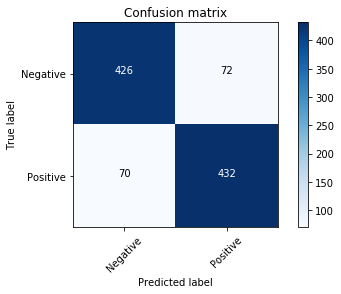

In [16]:
logistic_regression_limit = min(100000, len(X_sklearn_preprocessed))

logistic_regression = models.LogisticRegressionModel(
    nlp, dataset_id,
    C=1e5
)

accuracy = train_model_and_display_results(
    logistic_regression,
    X_sklearn_preprocessed[:logistic_regression_limit],
    y_train[:logistic_regression_limit],
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(logistic_regression, "logistic_reg_imdb", "IMDB Logistic Regression", metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': logistic_regression_limit,
        'Accuracy': accuracy,
        'Description': "Logistic Regression Analysis algorithm from Sklearn package, default options except C=1e5"
    })

## GradientBoostingModel

#### Training

Loading model...
Unable to load model, training...


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           1.3557           21.20s
         2           1.3289           21.02s
         3           1.3059           20.47s
         4           1.2854           19.95s
         5           1.2671           19.49s
         6           1.2498           19.04s
         7           1.2344           18.57s
         8           1.2195           18.14s
         9           1.2058           17.71s
        10           1.1915           17.25s
        11           1.1784           16.81s
        12           1.1672           16.43s
        13           1.1567           15.99s
        14           1.1468           15.57s
        15           1.1373           15.15s
        16           1.1282           14.72s
        17           1.1197           14.28s
        18           1.1113           13.85s
        19           1.1025           13.41s
        20           1.0947           12.96s
        21           1.0866           12.54s
        2

#### Overview of created model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=2,
              warm_start=False)

#### Model results

#### Predicted scores

,score,text
0,0.630584,"This movie is, in my opinion, very worth watching!"
1,0.242231,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.323044,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Highest 5

,pred,prob,real,text
721,1.000000,0.944278,1,"b'I chose ""The English Patient"" for a history extra credit assignment. I thought that this movie would be incredibly boring. I..."
762,1.000000,0.941567,1,"b""The movie has taken a little flack for playing fast and loose with the facts. But it will put you close to being in a time a..."
428,1.000000,0.935400,1,"b'These critics need to find a new job!!! This movie is based on a TRUE STORY, which has made history. It illustrates beautifu..."
302,1.000000,0.931832,1,"b""Fantastically written, acted, and produced! Loved seeing this gleaming, talented cast -- every single one of them -- give a ..."
491,1.000000,0.931161,1,"b""I did not know what to expect when I decided to watch this documentary. I knew it was about an ex-Viet Nam POW in Laos who e..."


#### Lowest 5

,pred,prob,real,text
265,0.000000,0.078968,0,"b'Idiots go camping and act like idiots before they finally die like idiots, yes Camp Blood (or if you\'re wanting an awful, b..."
507,0.000000,0.098646,0,b'There isn\'t enough space to explain the many ways this movie is a disappointing mess. Silly special effects and an incompre...
145,0.000000,0.099532,0,"b""I would rather have someone cut out my eyeballs with a razor blade than have to watch this movie again. I watched it from st..."
837,0.000000,0.101480,0,"b'As Anthony Bourdain said... ""I wanted to stick my head in a bucket of lye, pull my eyeballs out and jump off a cliff."" This ..."
870,0.000000,0.102493,0,"b'The spoof genre, which has lacked creativity and humor for some time already, gets spat upon yet again by hacks with no tale..."


#### Highest 5 mispredicted

,pred,prob,real,text
224,1.000000,0.894663,0,"b""Well, I think I've finally seen my last Woody Allen movie! I read the review in the newspaper and went to see this movie wit..."
523,1.000000,0.882861,0,"b""This film has the language, the style and the attitude down ... plus greats rides from Occy (a world champ) and the great Je..."
71,1.000000,0.833414,0,"b'I went to see this 3 nights ago here in Cork, Ireland. It was the world premiere of it, in the tiny cinema in the Triskel Ar..."
849,1.000000,0.803938,0,"b""Sadly, this movie is not very good. But does it really matter ? We all know the basics for the story, and this has nothing n..."
517,1.000000,0.799969,0,"b""Interesting and short television movie describes some of the machinations surrounding Jay Leno's replacing Carson as host of..."


#### Lowest 5 mispredicted

,pred,prob,real,text
924,0.000000,0.121088,1,"b""Might contain spoilers.<br /><br />This is just a good movie. Lots of good silly stuff to laugh at. However, do not watch th..."
326,0.000000,0.167972,1,b'I can\'t even begin to imagine why everyone hates this movie so much. It had me literally crying with laughter several times...
610,0.000000,0.188935,1,b'...and normally i don\'t like surprises!! Watch this movie by chance in a motel in South Africa second week of a three month...
244,0.000000,0.207768,1,"b""If a joke doesn't offend anybody, it isn't funny.<br /><br />The Inki cartoons are offensive, no doubt about it. So is rap m..."
189,0.000000,0.234603,1,"b""Yes. Bam cried a couple times and so did Englund. And most probably you will too. The whole cast is back in action and Knoxv..."


#### Classification report for gradientboostingclassifier

             precision    recall  f1-score   support

   Negative       0.80      0.79      0.79       498
   Positive       0.79      0.80      0.80       502

avg / total       0.80      0.80      0.79      1000



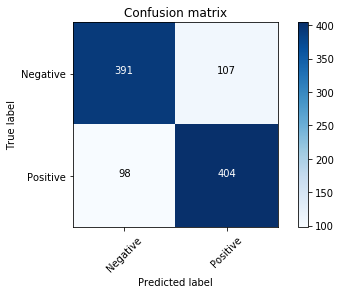

In [17]:
gradient_boosting_model = models.GradientBoostingModel(
    nlp, dataset_id,
    n_estimators=50, 
    max_depth=2,
    verbose=2
)

accuracy = train_model_and_display_results(
    gradient_boosting_model,
    X_sklearn_preprocessed, 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(gradient_boosting_model, "gradient_boost_imdb", "IMDB Gradient Boosting", metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': len(X_sklearn_preprocessed),
        'Accuracy': accuracy,
        'Description': "Gradient Boosting algorithm from Sklearn package, n_estimators=50, max_depth=2"
    })

## XGBModel

#### Training

Loading model...
Unable to load model, training...


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model 'xgbclassifier_imdb_all_5d69fa9f.pkl' saved


#### Overview of created model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, verbose_eval=1)

#### Model results

#### Predicted scores

,score,text
0,0.679294,"This movie is, in my opinion, very worth watching!"
1,0.325554,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.379419,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Highest 5

,pred,prob,real,text
384,1.000000,0.992945,1,"b""I had the chance to watch Blind Spot in Barcelona and I enjoyed it tremendously. I thought it to be one of the most captivat..."
428,1.000000,0.991122,1,"b'These critics need to find a new job!!! This movie is based on a TRUE STORY, which has made history. It illustrates beautifu..."
75,1.000000,0.987391,1,"b'For those that are great fans and collectors of dinosaurs like I am, it is not only a very informative series but also puts ..."
721,1.000000,0.984942,1,"b'I chose ""The English Patient"" for a history extra credit assignment. I thought that this movie would be incredibly boring. I..."
871,1.000000,0.983060,1,"b""What a great movie!! It's a touching story about four high-school friends who grow up in the 1960s. Throughout the decade, t..."


#### Lowest 5

,pred,prob,real,text
265,0.000000,0.011599,0,"b'Idiots go camping and act like idiots before they finally die like idiots, yes Camp Blood (or if you\'re wanting an awful, b..."
145,0.000000,0.019804,0,"b""I would rather have someone cut out my eyeballs with a razor blade than have to watch this movie again. I watched it from st..."
837,0.000000,0.019877,0,"b'As Anthony Bourdain said... ""I wanted to stick my head in a bucket of lye, pull my eyeballs out and jump off a cliff."" This ..."
309,0.000000,0.022773,0,"b'Well, Killshot is not awful, but it comes close. Production values are decent and the main actors do a pretty good job (exce..."
684,0.000000,0.023839,0,b'This movie had horrible lighting and terrible camera movements. This movie is a jumpy horror flick with no meaning at all. T...


#### Highest 5 mispredicted

,pred,prob,real,text
523,1.000000,0.947512,0,"b""This film has the language, the style and the attitude down ... plus greats rides from Occy (a world champ) and the great Je..."
224,1.000000,0.946282,0,"b""Well, I think I've finally seen my last Woody Allen movie! I read the review in the newspaper and went to see this movie wit..."
849,1.000000,0.937795,0,"b""Sadly, this movie is not very good. But does it really matter ? We all know the basics for the story, and this has nothing n..."
71,1.000000,0.928966,0,"b'I went to see this 3 nights ago here in Cork, Ireland. It was the world premiere of it, in the tiny cinema in the Triskel Ar..."
11,1.000000,0.910773,0,"b""Even Disney are guilty of the cash cow disease, after the roaring success of The Love Bug in 1968, the house of mouse cashed..."


#### Lowest 5 mispredicted

,pred,prob,real,text
924,0.000000,0.039572,1,"b""Might contain spoilers.<br /><br />This is just a good movie. Lots of good silly stuff to laugh at. However, do not watch th..."
244,0.000000,0.063431,1,"b""If a joke doesn't offend anybody, it isn't funny.<br /><br />The Inki cartoons are offensive, no doubt about it. So is rap m..."
326,0.000000,0.077508,1,b'I can\'t even begin to imagine why everyone hates this movie so much. It had me literally crying with laughter several times...
610,0.000000,0.145157,1,b'...and normally i don\'t like surprises!! Watch this movie by chance in a motel in South Africa second week of a three month...
742,0.000000,0.189125,1,"b""Not too bad entry in the series, heavily ladled with war propaganda, but Rathbone & Bruce's sincerity keep me happy.<br /><b..."


#### Classification report for xgbclassifier

             precision    recall  f1-score   support

   Negative       0.83      0.82      0.82       498
   Positive       0.83      0.83      0.83       502

avg / total       0.83      0.83      0.83      1000



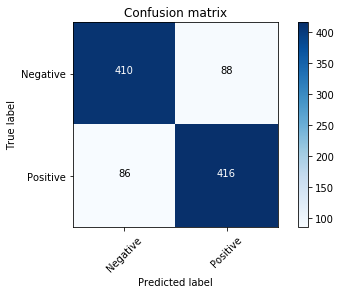

In [18]:
xgb_limit = min(50000, len(X_sklearn_preprocessed))
xgb_model = models.XGBModel(
    nlp, dataset_id, verbose_eval=1
)

accuracy = train_model_and_display_results(
    xgb_model,
    X_sklearn_preprocessed[:xgb_limit],
    y_train[:xgb_limit],
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(xgb_model, "xgboost_imdb", "IMDB XGBoost", metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': xgb_limit,
        'Accuracy': accuracy,
        'Description': "XGBoost using default parameters"
    })